In [146]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import pairwise_distances
import plotly.express as px
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import joblib
import warnings
warnings.filterwarnings(action='ignore') 

In [147]:
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
# display(HTML("<style>.prompt { display:none !important; }</style>"))

In [148]:
test_data = pd.read_csv("./dataset/test_data.csv")

In [149]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7389 entries, 0 to 7388
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     7389 non-null   float64
 1   air_end_temp   7389 non-null   float64
 2   out_pressure   7389 non-null   float64
 3   motor_current  7389 non-null   float64
 4   motor_rpm      7389 non-null   int64  
 5   motor_temp     7389 non-null   float64
 6   motor_vibe     7389 non-null   float64
 7   type           7389 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 461.9 KB


In [150]:
test_data.describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
count,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000
mean,2.103129,49.042735,0.699840,27.417935,2373.820003,65.771623,3.345523,2.957369
std,1.163998,8.686208,0.005377,13.234089,687.737182,7.741473,0.644199,2.229811
min,0.340000,32.080000,0.490000,5.370000,1200.000000,50.420000,1.970000,0.000000
25%,1.280000,41.510000,0.700000,17.200000,1774.000000,59.110000,2.890000,1.000000
50%,1.940000,48.760000,0.700000,26.170000,2355.000000,65.520000,3.260000,3.000000
75%,2.770000,56.580000,0.700000,35.860000,2972.000000,72.440000,3.730000,5.000000
max,6.240000,65.540000,0.700000,74.000000,3564.000000,82.390000,6.260000,7.000000


In [151]:
X_test = test_data.iloc[:,:-1]
y_test = test_data[['type']]

In [152]:
# PCA 대상 그룹핑으로 나누기
g1 = X_test[['air_inflow','motor_current']]
g2 = X_test[['air_end_temp', 'motor_rpm', 'motor_temp']]
g3 = X_test[['motor_vibe']]
combined = [g1, g2, g3]

In [153]:
sc = StandardScaler()
# sc = MinMaxScaler()
scaled_list = []
for i in combined:
    result = sc.fit_transform(i)
    scaled_list.append(result)
len(scaled_list)

3

In [154]:
pca = PCA(n_components=1)
pca_list = []
for i in scaled_list:
    result = pca.fit_transform(i)
    total_var = pca.explained_variance_ratio_.sum() * 100
    pca_list.append(result)
    print(f"{i}total_var : {total_var}")

[[ 0.34956982  0.38706193]
 [ 0.47844475  0.53139596]
 [-0.32917145 -0.39203953]
 ...
 [-0.46663804 -0.54922004]
 [-0.44086306 -0.52126004]
 [-0.34635478 -0.40866439]]total_var : 99.55080635654551
[[ 0.48784827  0.4190547   0.49197811]
 [ 0.71350861  0.64735503  0.71675676]
 [-0.7256517  -0.80678719 -0.71846784]
 ...
 [-0.97088462 -1.05399137 -0.96262396]
 [-0.92713414 -1.0103671  -0.91870169]
 [-0.75213225 -0.83296175 -0.74430447]]total_var : 99.22881044537634
[[ 0.20876468]
 [ 0.34848248]
 [-0.52087275]
 ...
 [-0.66059055]
 [-0.64506635]
 [-0.53639695]]total_var : 100.0


In [155]:
pca_list[0]

array([[ 0.52087731],
       [ 0.71406521],
       [-0.50997318],
       ...,
       [-0.71832014],
       [-0.68032377],
       [-0.53387918]])

In [156]:
# 2D 리스트를 1D로 Flatten
flat_pca_list = []
for i in pca_list:
    result = [j for sub in i for j in sub]
    flat_pca_list.append(result)

In [157]:
pca_df = pd.DataFrame({"PC1": flat_pca_list[0], "PC2": flat_pca_list[1], "PC3": flat_pca_list[2]})
pca_df.head()

,PC1,PC2,PC3
0,0.520877,-0.807738,0.208765
1,0.714065,-1.199604,0.348482
2,-0.509973,1.299447,-0.520873
3,0.116671,0.017558,-0.070671
4,-0.066167,0.392344,-0.210389


In [158]:
pca_test = pd.concat([pca_df, y_test], axis=1)
pca_test.head()

,PC1,PC2,PC3,type
0,0.520877,-0.807738,0.208765,0
1,0.714065,-1.199604,0.348482,0
2,-0.509973,1.299447,-0.520873,0
3,0.116671,0.017558,-0.070671,0
4,-0.066167,0.392344,-0.210389,0


In [159]:
fig = px.scatter_3d(
    pca_test, x='PC1', y='PC2', z='PC3', color='type',symbol='type', opacity=0.5, size_max=10,height=600,
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [160]:
dbscan = joblib.load('./models/dbscan.joblib')

In [161]:
X_test = pca_test.iloc[:,:-1]
y_test = pca_test[['type']]

In [162]:
labels = dbscan.fit_predict(X_test)
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [163]:
X_test['label'] = labels
X_test

,PC1,PC2,PC3,label
0,0.520877,-0.807738,0.208765,0
1,0.714065,-1.199604,0.348482,0
2,-0.509973,1.299447,-0.520873,0
3,0.116671,0.017558,-0.070671,0
4,-0.066167,0.392344,-0.210389,0
...,...,...,...,...
7384,0.011963,0.231736,-0.148292,0
7385,-0.818219,1.921813,-0.738212,0
7386,-0.718320,1.724716,-0.660591,0
7387,-0.680324,1.648911,-0.645066,0


In [164]:
X_test['label'].value_counts()

 0     3982
-1      581
 3      155
 11     105
 29      80
       ... 
 96       8
 95       8
 51       8
 50       8
 98       8
Name: label, Length: 100, dtype: int64

In [165]:
sil_score = silhouette_score(X_test, labels)
sil_score

0.33759080845170275

In [166]:
X_test = pd.concat([X_test, y_test], axis=1)
X_test.head()

,PC1,PC2,PC3,label,type
0,0.520877,-0.807738,0.208765,0,0
1,0.714065,-1.199604,0.348482,0,0
2,-0.509973,1.299447,-0.520873,0,0
3,0.116671,0.017558,-0.070671,0,0
4,-0.066167,0.392344,-0.210389,0,0


In [167]:
fig = px.scatter_3d(
    X_test, x='PC1', y='PC2', z='PC3', color='label',symbol='type', opacity=0.5, size_max=10,height=600,
)
fig.show()

In [168]:
X_test.describe().round(2)

,PC1,PC2,PC3,label,type
count,7389.00,7389.00,7389.00,7389.00,7389.00
mean,0.00,0.00,0.00,13.47,2.96
std,1.41,1.73,1.00,23.23,2.23
min,-2.25,-3.17,-2.14,-1.00,0.00
25%,-1.05,-1.50,-0.71,0.00,1.00
50%,-0.16,0.04,-0.13,0.00,3.00
75%,0.85,1.51,0.60,19.00,5.00
max,4.90,3.25,4.52,98.00,7.00


In [169]:
def 결과정리(label):
    if label == -1:
        return 1
    else:
        return 0
        

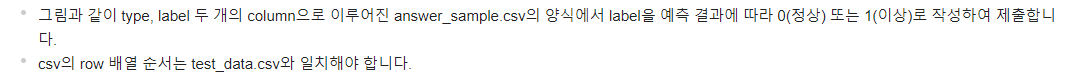

In [170]:
X_test['label'] = X_test['label'].apply(결과정리)

In [171]:
fig = px.scatter_3d(
    X_test, x='PC1', y='PC2', z='PC3', color='label',symbol='type', opacity=0.5, size_max=10,height=800,
)
fig.show()

In [172]:
submit_df = X_test[['type', 'label']]

In [173]:
submit_df['label'].value_counts()

0    6808
1     581
Name: label, dtype: int64

In [174]:
submit_df.to_csv('./submits/submit_20230410_01.csv', index=False)